
... ***CURRENTLY UNDER DEVELOPMENT*** ...


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# basic import
import os
import os.path as op
from collections import OrderedDict

# python libs
import numpy as np
import xarray as xr
from scipy.stats import linregress
from scipy.optimize import least_squares
from datetime import datetime, timedelta

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..','..', '..'))

# teslakit
from teslakit.tides import Calculate_MMSL
from teslakit.statistical import runmean
from teslakit.util.time_operations import date2yearfrac as d2yf
from teslakit.io.aux_nc import StoreBugXdset

from teslakit.plotting.tides import Plot_Tide_SLR, Plot_Tide_RUNM, Plot_Tide_MMSL, \
Plot_Validate_MMSL_tseries, Plot_Validate_MMSL_scatter, Plot_MMSL_Prediction, \
Plot_MMSL_Histogram



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

site ='ROI'
p_data = r'/Users/albacid/Projects/TeslaKit_projects/sites/' + site + '/'

p_outputs = p_data + 'ClimateChange/'

## 02 Simulate Monthly Mean Sea Level using a non-linear regression model 

inputs required: 
  * parameters of the fitted model
  * AWTs simulated PCs (under climate change)


In [3]:
# --------------------------------------
# load data and set parameters

SST_PCs_sim_m = xr.open_dataset(p_outputs + 'CC_SST_PCs_sim_m.nc') # climate change simulated SST PCs (monthly)
sim_params = xr.open_dataset(p_data + 'TIDE/tide_mmsl_sim_params.nc') # MMSL non linear regress model coef 

# parameters for mmsl calculation
mmsl_year_ini = 1996
mmsl_year_end = 2017


In [4]:
# --------------------------------------
# Predict 1000 years using simulated PCs (monthly time resolution)
sim_params = sim_params['sim_params'].values

# get simulation time as year fractions
PCs_sim_time = SST_PCs_sim_m.time.values[:]
frac_year_sim = np.array([d2yf(x) for x in PCs_sim_time])

# solve each PCs simulation
def modelfun(x, t, pc1, pc2, pc3, y):
    return x[0] + x[1]*pc1 + x[2]*pc2 + x[3]*pc3 + \
            np.array([x[4] + x[5]*pc1 + x[6]*pc2 + x[7]*pc3]).flatten() * np.cos(2*np.pi*t) + \
            np.array([x[8] + x[9]*pc1 + x[10]*pc2 + x[11]*pc3]).flatten() * np.sin(2*np.pi*t) + \
            np.array([x[12] + x[13]*pc1 + x[14]*pc2 + x[15]*pc3]).flatten() * np.cos(4*np.pi*t) + \
            np.array([x[16] + x[17]*pc1 + x[18]*pc2 + x[19]*pc3]).flatten() * np.sin(4*np.pi*t) - y

l_MMSL_sim = []
for s in SST_PCs_sim_m.n_sim:
    
    PCs_s_m = SST_PCs_sim_m.sel(n_sim=s)
    MMSL_PC1_sim = PCs_s_m.PC1.values[:]
    MMSL_PC2_sim = PCs_s_m.PC2.values[:]
    MMSL_PC3_sim = PCs_s_m.PC3.values[:]

    # use non-linear-model
    y_0s = np.zeros(frac_year_sim.shape)
    y_sim = modelfun(sim_params, frac_year_sim, MMSL_PC1_sim, MMSL_PC2_sim, MMSL_PC3_sim, y_0s)

    # append simulated MMSL
    l_MMSL_sim.append(
        xr.Dataset(
            {
                'mmsl' : (('time',), y_sim / 1000),  # mm to m
            },
            {'time' : PCs_sim_time}
        )
    )
    
# concatenate simulations
MMSL_sim = xr.concat(l_MMSL_sim, 'n_sim')
print(MMSL_sim)

StoreBugXdset(MMSL_sim, p_outputs + 'CC_tide_mmsl_sim.nc')


<xarray.Dataset>
Dimensions:  (n_sim: 10, time: 12012)
Coordinates:
  * time     (time) object 1699-06-01 00:00:00 ... 2700-05-01 00:00:00
Dimensions without coordinates: n_sim
Data variables:
    mmsl     (n_sim, time) float64 0.04477 -0.03554 -0.129 ... 0.04964 0.06207



MMSL Simulation 0


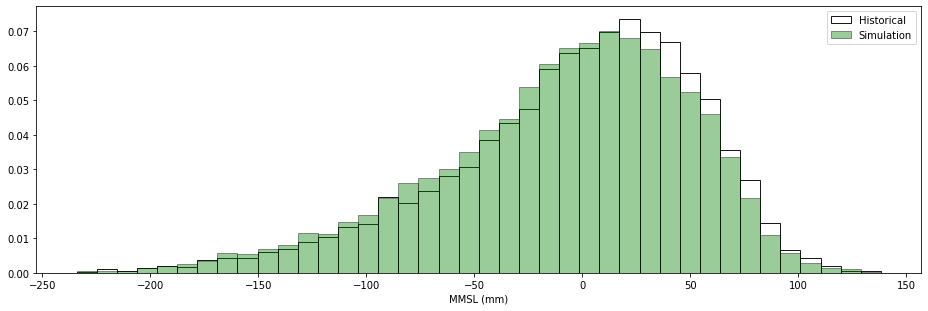


MMSL Simulation 1


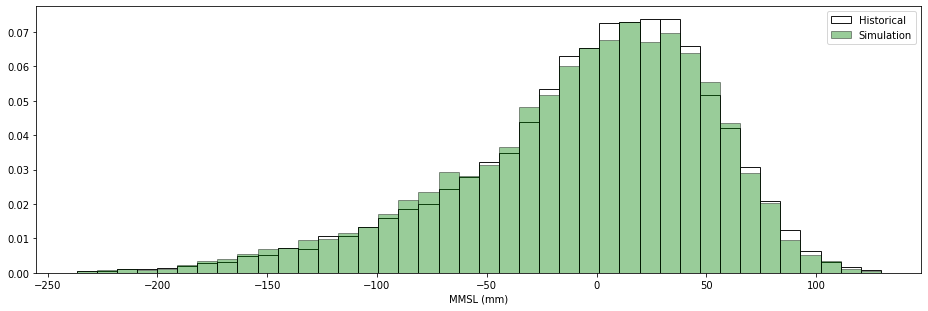


MMSL Simulation 2


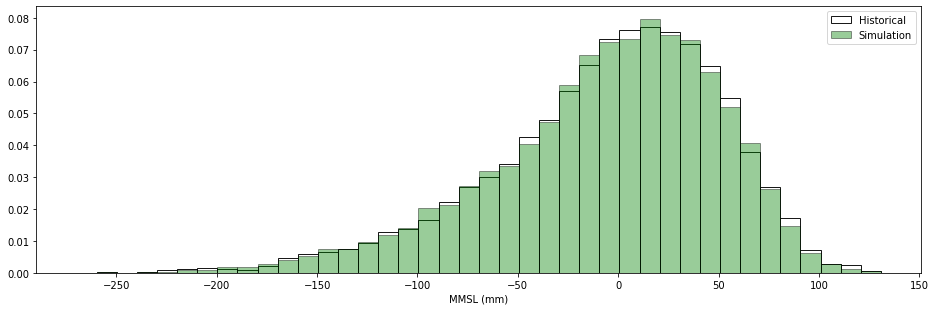


MMSL Simulation 3


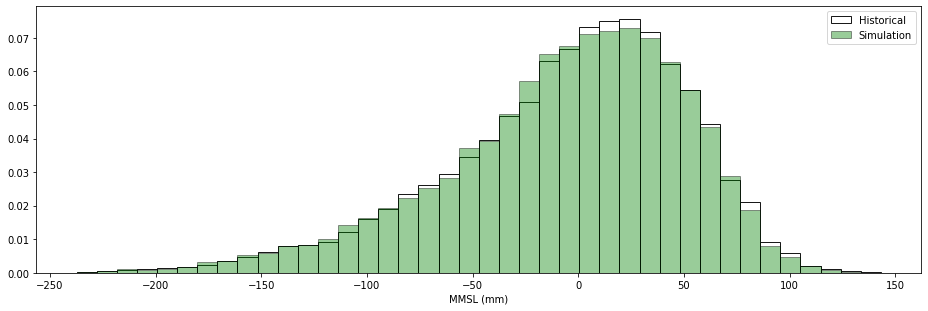


MMSL Simulation 4


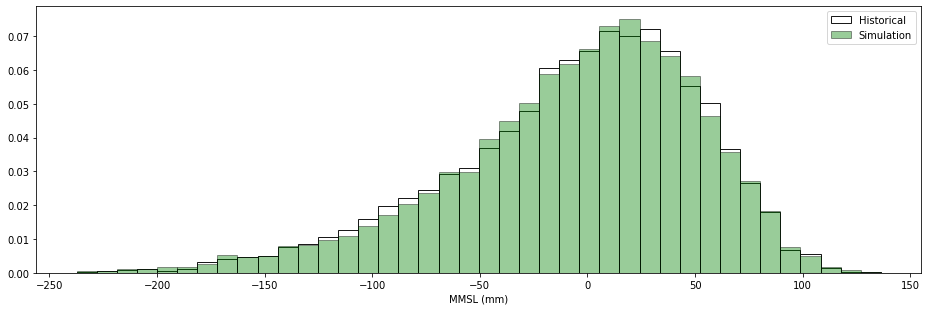


MMSL Simulation 5


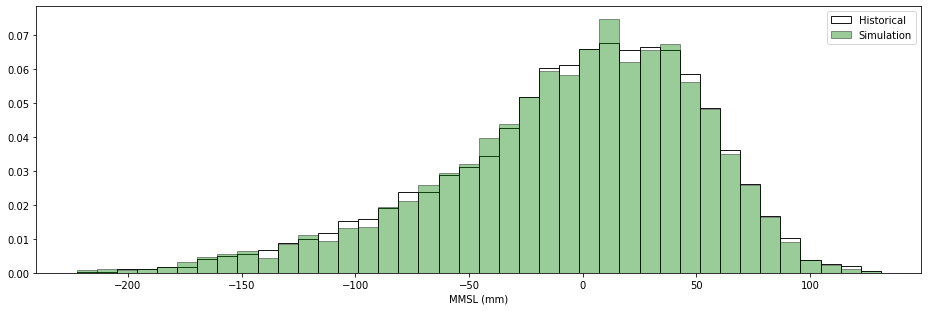


MMSL Simulation 6


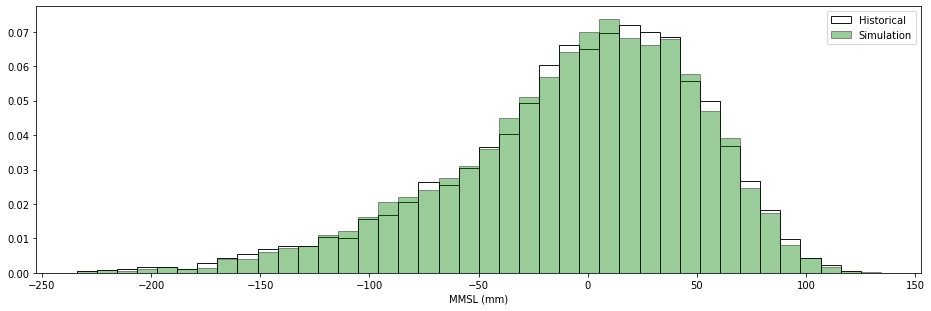


MMSL Simulation 7


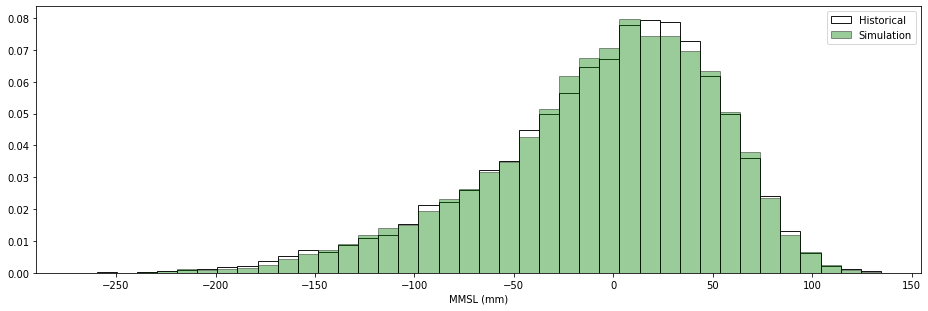


MMSL Simulation 8


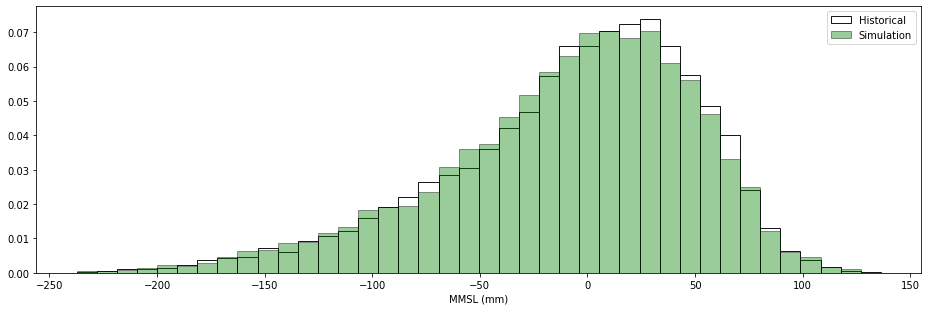


MMSL Simulation 9


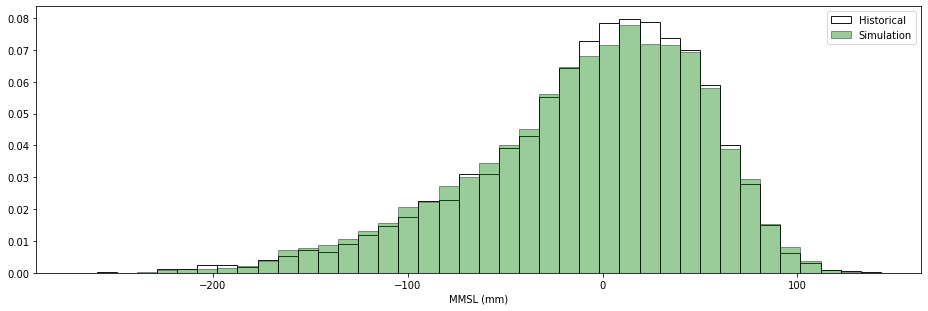

In [6]:
MMSL_sim_old = xr.open_dataset(p_data + 'TIDE/tide_mmsl_sim.nc')
    
# Plot each simulation prediction

for s in MMSL_sim.n_sim: 
    print('\nMMSL Simulation {0}'.format(s.values))

    y_sim = MMSL_sim.sel(n_sim=s).mmsl.values[:] * 1000  # m to mm
    t_sim = MMSL_sim.sel(n_sim=s).time.values[:]
    y_p = MMSL_sim_old.sel(n_sim=s).mmsl.values[:] * 1000  # m to mm


    # compare to mmsl prediction without climate change
    Plot_MMSL_Histogram(y_p, y_sim);
    
    # TODO: Change legend: 
        # historical --> simulation
        # simulation --> simulation with climate change
    
    